In [265]:
import nba_api 
from nba_api.stats.static import teams
from nba_api.stats.static import players
from nba_api.stats.endpoints import FranchisePlayers as fp
from nba_api.stats.endpoints import CommonPlayerInfo as cp
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.spatial import distance
from sklearn import preprocessing as pre
import numpy as np 


<h2> Retrieving Data </h2>

In [266]:
#storing all teams and players into lists
teams_list = teams.get_teams()
players_list = players.get_players()


#storing raptors teamid 
raptors_id = '1610612761'



In [267]:
#This extracts all players that ever played for the raptors 
tor_players = fp(league_id='00', per_mode_detailed='PerGame', season_type_all_star='Regular Season', team_id=raptors_id)

#stroing all raptors players in a dataframe 
tor_players_df = tor_players.get_data_frames()[0]




In [268]:
# this is just code to work mess around with data frames and understand them better 

# tor_players_df.iloc[20:25]
# tor_players_df.loc[tor_players_df['GP']>200]
# tor_players_df['PLAYER']
# tor_players_df = tor_players_df.sort_values(by=['GP'],ascending=False)
#tor_players_df.columns

<h2> Adding helper methods </h2>
<p> The stats that we want from players to include are pts, reb, ast, stl, blk, tov, pf which are already in this data frame. But to make the most accurate comparisons we are going to want TS% 3PAr and FTr which are not in the df therefore have to be calculated. These helper methods make such calculations </p>

In [269]:
#Helper methods that take in the original data frame and output each stat 
def add_true_shooting(df):
    list_of_TS = []
    #goes through each row of the df and uses data to calculate each stat
    for index, player in df.iterrows():
        #this if statement prevents a divide by zero exception
        if(player['FGA']==0):
            list_of_TS.append(0.00000)
            continue
        ts = player['PTS']/(2*(player['FGA']+(0.44*player['FTA'])))
        #appends this calculated stat to the list 
        list_of_TS.append(ts)
    #adds list to dataframe with proper header    
    df['TS'] = list_of_TS
    return df

#these are methods are similar to the one above just implementing their own stat
def add_3PAr(df):
    list_of_3PAr = []
    for index, player in df.iterrows():
        if(player['FGA']==0):
            list_of_3PAr.append(0.00000)
            continue
        val = player['FG3A']/player['FGA']
        list_of_3PAr.append(val)
       
    df['3PAr'] = list_of_3PAr
    return df

def add_FTr(df):
    list_of_FTr = []
    for index, player in df.iterrows():
        if(player['FGA']==0):
            list_of_FTr.append(0.00000)
            continue
        val = player['FTA']/player['FGA']
        list_of_FTr.append(val)
       
    df['FTr'] = list_of_FTr
    return df

In [270]:
#adding true shooting 3PAr and FTr to our data frame 
tor_players_df = add_true_shooting(add_3PAr(add_FTr(tor_players_df )))

#tor_players_df.head(30)

<h2> Extracting Players we want </h2>

85.38135593220339


[]

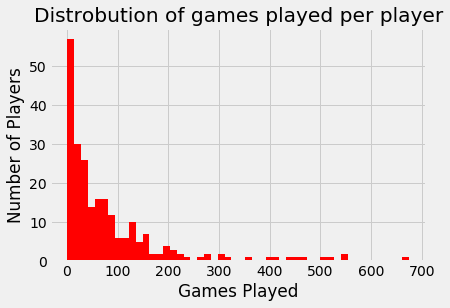

In [271]:
#checking what is the average number of games played 
print(tor_players_df['GP'].mean())

#tor_players_df.hist(column='GP').show()
plt.style.use('fivethirtyeight')

gamesPlayedHist, g = plt.subplots()

g.hist(tor_players_df['GP'],color='red',bins=50)
g.set_xlabel("Games Played")
g.set_ylabel("Number of Players")
g.set_title("Distrobution of games played per player")
g.plot()

In [272]:
#Only stroing players that have played over 50 games for the raptors
tor_players_df = tor_players_df.sort_values(by=['GP'],ascending=False)

################# COMMENT OUT THIS LINE IF YOU WANT ALL PLAYERS ########################################
tor_players_df =  tor_players_df.loc[tor_players_df['GP']>50]
########################################################################################################
names = tor_players_df['PLAYER']
#tor_players_df 
tor_players_df .loc[(tor_players_df ['PLAYER'] == 'Malcolm Miller')]
# tor_players_df

,LEAGUE_ID,TEAM_ID,TEAM,PERSON_ID,PLAYER,SEASON_TYPE,ACTIVE_WITH_TEAM,GP,FGM,FGA,...,REB,AST,PF,STL,TOV,BLK,PTS,FTr,3PAr,TS


In [273]:
#here we are going to take the stats that are important for our comparisons
#tor_players_df = tor_players_df[['PLAYER','PTS', 'AST', 'REB', 'STL','BLK','TS','3PAr', 'FTr','TOV','PF'] ]

df_tor_numbers = tor_players_df[['PTS', 'AST', 'REB', 'STL','BLK','TS','3PAr', 'FTr','TOV','PF']]
avg_player = df_tor_numbers.mean()


avg_player

PTS     8.853353
AST     1.971658
REB     3.914966
STL     0.733922
BLK     0.482563
TS      0.526064
3PAr    0.234889
FTr     0.280735
TOV     1.244734
PF      2.099064
dtype: float64

<h2> Finding the most average raptors player </h2> 
<p> Here we are going do normalize the dataframes so that the distance measurements will be of equal weights. Then we will find how similar each player's stats are to the average by finding the distance between stat vectors. This measurement will be made using eucliadian distance and cosine similarity </p> 

In [274]:
#Firsr we have to append the mean average player to a dataframe
avg_player_df = pd.DataFrame([avg_player])
df_to_normalize = pd.concat([df_tor_numbers,avg_player_df])


In [275]:
#now we have to normalize the data 
x = df_to_normalize.values #returns a numpy array
min_max_scaler = pre.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalized_data = pd.DataFrame(x_scaled)

df_normalized_data.iloc[115]

0    0.294704
1    0.202357
2    0.388346
3    0.294454
4    0.168897
5    0.502589
6    0.281096
7    0.279818
8    0.331322
9    0.436808
Name: 115, dtype: float64

In [276]:
#here we are splitting the normalized data back into 2 dataframes 
# df_players = df_normalized_data.iloc[:115]
# df_avg = df_normalized_data.iloc[115]

df_normalized_data

,0,1,2,3,4,5,6,7,8,9
0,0.725688,0.324124,0.404321,0.411777,0.095926,0.537886,0.128171,0.426197,0.537011,0.477523
1,0.641347,0.767955,0.493620,0.667796,0.112841,0.681379,0.602138,0.359558,0.728180,0.712065
2,0.419320,0.181322,0.376394,0.435634,0.078782,0.516321,0.464316,0.224511,0.309226,0.564175
3,0.339139,0.775438,0.230604,0.373552,0.030000,0.674451,0.333955,0.184048,0.469638,0.312518
4,0.745117,0.226440,1.000000,0.317297,0.412573,0.668714,0.027368,0.550787,0.609531,0.608109
...,...,...,...,...,...,...,...,...,...,...
111,0.096571,0.033194,0.077058,0.108167,0.105660,0.283335,0.341065,0.208900,0.222963,0.087987
112,0.086534,0.108158,0.204258,0.302431,0.134615,0.500017,0.074795,0.265823,0.211172,0.024003
113,0.229454,0.175857,0.496809,0.350142,0.148077,0.528580,0.068964,0.462619,0.244353,0.410095
114,0.716659,0.274502,0.707112,0.757274,0.308823,0.392564,0.252641,0.246525,0.836085,0.666102


In [277]:
#we are going to use test this using euclidian distance and cosine distance 
#I read euclidian is more useful so that will be the baseline 
cos_dist = []
e_dist = []
for name in names:
    i = list(names).index(name)
    
    e_dist.append([name, distance.euclidean(df_normalized_data.iloc[-1],df_normalized_data.iloc[i])])
    cos_dist.append([name,1 - distance.cosine(df_normalized_data.iloc[-1],df_normalized_data.iloc[i])])
    
e_most_simlar = sorted(e_dist, key=lambda x: x[1])
cos_most_simlar = sorted(cos_dist, key=lambda x: x[1], reverse= True)

e_most_simlar

[['James Johnson', 0.24252302514836083],
 ['Cory Joseph', 0.2659285637659849],
 ['Luis Scola', 0.27324797965737585],
 ['Tracy Murray', 0.29557814090871104],
 ['Morris Peterson', 0.3125612618303998],
 ['Rondae Hollis-Jefferson', 0.32806707361322235],
 ['Voshon Lenard', 0.333332089802422],
 ['Sonny Weems', 0.33951359136241777],
 ['Linas Kleiza', 0.3398481380733425],
 ['Carlos Rogers', 0.3406711677498104],
 ['Anthony Parker', 0.3461567912964696],
 ['Leandro Barbosa', 0.34674480941873065],
 ['Pascal Siakam', 0.35473386298078613],
 ['Carlos Delfino', 0.3608086428191745],
 ['Alan Anderson', 0.36917871480110676],
 ['Joey Graham', 0.38035677294155473],
 ['Juan Dixon', 0.38390534230670387],
 ['Antoine Wright', 0.39216702270021025],
 ['Norman Powell', 0.3928581107693463],
 ['Jerryd Bayless', 0.39532757152157744],
 ['Lamond Murray', 0.4026866738887718],
 ['Andrea Bargnani', 0.41434761819565236],
 ['OG Anunoby', 0.422956998733216],
 ['Jelani McCoy', 0.444501055583018],
 ['Jamario Moon', 0.44495366

<p> NOTE: Euclidian distance seemed to give more reasonable results from the eye test although both gave similar outputs. From reading things online euclidian is the better suited measurement for something like this anyways so that makes sense </p>